<a href="https://www.kaggle.com/code/aaliyahraderberg/parasites-detection-in-keras?scriptVersionId=201737268" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

## Loading the cell image data

Different methods can be utilized for ensemble learning, and a concise overview can be found on Wikipedia. Broadly speaking, ensemble learning falls into two main categories:
* Bagging: This involves training separate models independently and then averaging their predictions.
* Boosting: This entails sequentially training multiple models and then averaging their predictions.

For this particular project, we will be implementing a simplified version of the bagging approach:
* Fit a set of independent models.
* Collect predictions from each model.
* Apply a voting mechanism.

When it comes to voting procedures based on predictions from multiple models, there are two main options:
* Hard Voting: Select the most frequently predicted class.


In [1]:
#import required libraries
#!pip3 install keras tensorflow sklearn matplotlib opencv-python pandas

import statistics
import os
import glob
import numpy as np
import pandas as pd
from concurrent import futures
import threading

import tensorflow as tf
from keras.optimizers import SGD, Adam
from keras.layers import Conv2D, Activation, Dense, MaxPooling2D, Flatten, Dropout
from keras.models import Sequential

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score, precision_score, recall_score, classification_report

import cv2
import matplotlib.pyplot as plt

In [2]:
# datasets found in Kaggle cell-images
infected = '/kaggle/input/cell-images/cell_images/test/parasitized'
healthy = '/kaggle/input/cell-images/cell_images/test/uninfected'

infected_files = glob.glob(infected+'/*.png')
healthy_files = glob.glob(healthy+'/*.png')

files_df = pd.DataFrame({
    'img': infected_files + healthy_files,
    'malaria': [1] * len(infected_files) + [0] * len(healthy_files)
})

files_df = files_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Just to reduce complexity
files_df = files_df.iloc[0:2000, :]
files_df['malaria'].value_counts()

malaria
0    1006
1     994
Name: count, dtype: int64

## Transform the image files into arrays and create the datasets

/kaggle/input/cell-images/cell_images/test/uninfected/C67P28N_ThinF_IMG_20150819_121053_cell_152.png
/kaggle/input/cell-images/cell_images/test/parasitized/C97P58ThinF_IMG_20150917_150838_cell_160.png
/kaggle/input/cell-images/cell_images/test/parasitized/C39P4thinF_original_IMG_20150622_105803_cell_86.png
/kaggle/input/cell-images/cell_images/test/uninfected/C37BP2_thinF_IMG_20150620_133238a_cell_22.png
/kaggle/input/cell-images/cell_images/test/uninfected/C166P127ThinF_IMG_20151117_194410_cell_30.png
/kaggle/input/cell-images/cell_images/test/uninfected/C124P85ThinF_IMG_20151002_155101_cell_140.png
/kaggle/input/cell-images/cell_images/test/uninfected/C127P88ThinF_IMG_20151004_112418_cell_99.png
/kaggle/input/cell-images/cell_images/test/parasitized/C136P97ThinF_IMG_20151005_144449_cell_32.png
/kaggle/input/cell-images/cell_images/test/parasitized/C174P135NThinF_IMG_20151127_135512_cell_182.png
/kaggle/input/cell-images/cell_images/test/uninfected/C240ThinF_IMG_20151127_115247_cell_6

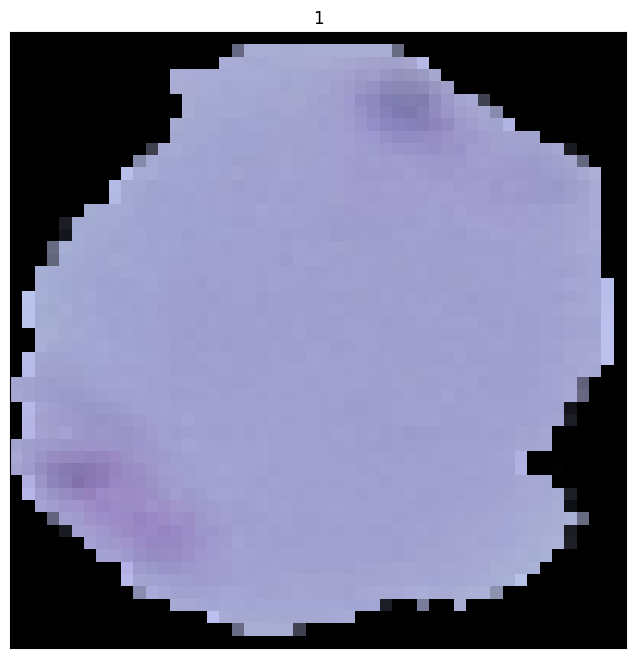

In [3]:
img_length, img_width = 50, 50


def get_data(data_files):
    data = []
    for img in data_files:
        print(img)
        img = cv2.imread(img)
        img = cv2.resize(img, dsize=(img_length, img_width),
                         interpolation=cv2.INTER_CUBIC)
        img = np.array(img)
        data += [img]
    return np.array(data)

X = files_df['img'].values
y = files_df['malaria'].values

X_converted = get_data(X)/255.0

train_data, val_data, train_labels, val_labels = train_test_split(
    X_converted, y, test_size=0.2, random_state=42)

# Check images

plt.figure(figsize=(8, 8))
plt.imshow(train_data[0])
plt.title('{}'.format(train_labels[0]))
plt.xticks([])
plt.yticks([])
plt.savefig('sample')

## Create a deep CNN

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam

# Create a Sequential model
model = Sequential()
model.add(Input(shape=(img_length, img_width, 3)))  # Using Input layer to define input shape
model.add(Conv2D(16, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(16, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# Display model summary
model.summary()

# Define the optimizer with the correct argument
adam = Adam(learning_rate=0.001)

# Compile the model
model.compile(optimizer=adam,
              loss='binary_crossentropy',
              metrics=['accuracy'])


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 48, 48, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 24, 24, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 22, 22, 16)     │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 11, 11, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 9, 9, 32)       │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │        16,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,857 (93.19 KB)

 Trainable params: 23,857 (93.19 KB)

 Non-trainable params: 0 (0.00 B)

## Train and test the CNN

Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 73ms/step - accuracy: 0.4964 - loss: 0.6947 - val_accuracy: 0.5100 - val_loss: 0.6925
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - accuracy: 0.5000 - loss: 0.6933 - val_accuracy: 0.5950 - val_loss: 0.6915
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.5428 - loss: 0.6917 - val_accuracy: 0.6075 - val_loss: 0.6870
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 0.5676 - loss: 0.6853 - val_accuracy: 0.4900 - val_loss: 0.6931
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 74ms/step - accuracy: 0.6122 - loss: 0.6596 - val_accuracy: 0.5825 - val_loss: 0.6627
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - accuracy: 0.6222 - loss: 0.6516 - val_accuracy: 0.7000 - val_loss: 0.6213
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - accuracy: 0.6932 - loss: 0.6100 - val_accuracy: 0.6775 - val_loss: 0.6171
Epoch 8/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 0.7051 - loss: 0.6009 - val_accuracy: 0.6175 - v

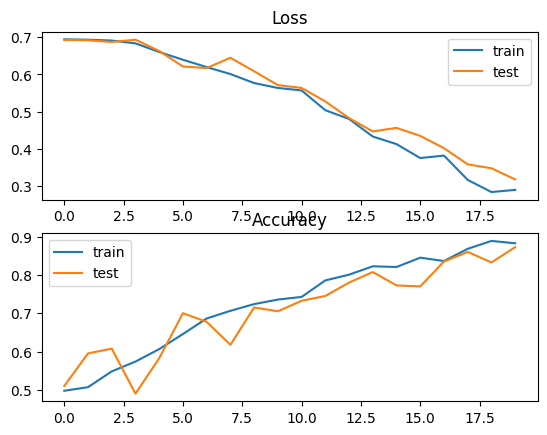

In [5]:
# Train the model
history = model.fit(x=train_data, y=train_labels, batch_size=64, epochs=20,
                    verbose=1, shuffle=True, validation_data=(val_data, val_labels))

# Predict class probabilities
y_predicted_prob = model.predict(val_data)

# Convert probabilities to class labels (for binary classification)
y_predicted = (y_predicted_prob > 0.5).astype(int)

# Calculate and print metrics
print('Accuracy: ', accuracy_score(val_labels, y_predicted))
print('Precision: ', precision_score(val_labels, y_predicted))
print('Recall: ', recall_score(val_labels, y_predicted))
print('f1: ', f1_score(val_labels, y_predicted))

# Print the classification report
print(classification_report(val_labels, y_predicted))

# Plot loss and accuracy
plt.subplot(211)
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()

plt.subplot(212)
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()

# Save the plot
plt.savefig('accuracy_loss')


## Create the CNN models ensemble

In [6]:
from tensorflow.keras.layers import Input

models = {}

for j in range(2, 4):
    # Define the model with Input layer
    newmodel = Sequential()
    newmodel.add(Input(shape=(img_length, img_width, 3)))
    newmodel.add(Conv2D(j*16, (3, 3), activation='relu'))
    newmodel.add(MaxPooling2D(pool_size=(2, 2)))
    newmodel.add(Conv2D(j*16, (3, 3), activation='relu'))
    newmodel.add(MaxPooling2D(pool_size=(2, 2)))
    newmodel.add(Conv2D(j*32, (3, 3), activation='relu'))
    newmodel.add(MaxPooling2D(pool_size=(2, 2)))
    newmodel.add(Flatten())
    newmodel.add(Dense(j*32, activation='relu'))
    newmodel.add(Dropout(0.5))
    newmodel.add(Dense(1, activation='sigmoid'))

    # Compile the model
    newmodel.compile(optimizer=adam,
                     loss='binary_crossentropy',
                     metrics=['accuracy'])

    # Display model summary
    newmodel.summary()

    # Store the model in the dictionary
    models[j] = newmodel


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 48, 48, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 22, 22, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 11, 11, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 9, 9, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │        65,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 142,021 (554.77 KB)

 Trainable params: 94,305 (368.38 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 47,716 (186.39 KB)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 48, 48, 48)     │         1,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 24, 24, 48)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 22, 22, 48)     │        20,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 11, 11, 48)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 9, 9, 96)       │        41,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 4, 4, 96)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 1536)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 96)             │       147,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            97 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 259,061 (1011.96 KB)

 Trainable params: 211,345 (825.57 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 47,716 (186.39 KB)

## Fit the models in the ensemble and perform the prediction

In [7]:
for j in models:
    # Create a new Adam optimizer for each model
    adam = Adam(learning_rate=0.001)
    
    # Compile the model with a new optimizer
    models[j].compile(optimizer=adam,
                      loss='binary_crossentropy',
                      metrics=['accuracy'])

    # Train the model
    models[j].fit(x=train_data, y=train_labels, batch_size=64, epochs=25,
                  verbose=1, shuffle=True, validation_data=(val_data, val_labels))


Epoch 1/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 116ms/step - accuracy: 0.5025 - loss: 0.6973 - val_accuracy: 0.5600 - val_loss: 0.6841
Epoch 2/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - accuracy: 0.5899 - loss: 0.6713 - val_accuracy: 0.6675 - val_loss: 0.6318
Epoch 3/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 101ms/step - accuracy: 0.6758 - loss: 0.6196 - val_accuracy: 0.6175 - val_loss: 0.6410
Epoch 4/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 97ms/step - accuracy: 0.6835 - loss: 0.6056 - val_accuracy: 0.7100 - val_loss: 0.5901
Epoch 5/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 97ms/step - accuracy: 0.6981 - loss: 0.5834 - val_accuracy: 0.7675 - val_loss: 0.5543
Epoch 6/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - accuracy: 0.7793 - loss: 0.5231 - val_accuracy: 0.7575 - val_loss: 0.5145
Epoch 7/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 98ms/step - accuracy: 0.7860 - loss: 0.4815 - val_accuracy: 0.8050 - val_loss: 0.4339
Epoch 8/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 96ms/step - accuracy: 0.8523 - loss: 0.3858 - val_accuracy: 0.8325 -

## Apply hard voting to the ensemble

In [8]:
import numpy as np
from statistics import mode
from sklearn.metrics import classification_report

# Initialize predictions_hard list
predictions_hard = []

# Collect predictions from each model
for j in models:
    # Use predict() instead of predict_classes(), and threshold the probabilities
    y_predicted_probs = models[j].predict(val_data)
    y_predicted = (y_predicted_probs > 0.5).astype("int32").flatten()  # Store predictions as a flat array
    predictions_hard.append(y_predicted)
    print(f'Model {j} predictions shape: {y_predicted.shape}')  # Debugging line

# Check the number of predictions from each model
print(f'Number of models: {len(predictions_hard)}')
for idx, preds in enumerate(predictions_hard):
    print(f'Length of predictions_hard[{idx}]: {len(preds)}')  # Debugging line

# Ensure all predictions have the same length
min_length = min(len(preds) for preds in predictions_hard)
print(f'Minimum length of predictions: {min_length}')

# Combine predictions using majority voting
voting_hard = []
for i in range(min_length):  # Use the minimum length to avoid IndexError
    try:
        # Corrected indexing to just access predictions_hard[j][i]
        vote = mode([predictions_hard[0][i], predictions_hard[1][i]])
        voting_hard.append(vote)
    except IndexError as e:
        print(f'IndexError at prediction index {i}: {e}')
    except Exception as e:
        print(f'Error at prediction index {i}: {e}')

# Check voting_hard length before classification report
print(f'Length of voting_hard: {len(voting_hard)}')

# Print classification report for hard voting results if voting_hard has predictions
if len(voting_hard) > 0:
    print(classification_report(val_labels[:len(voting_hard)], voting_hard))  # Ensure val_labels matches length
else:
    print("No predictions in voting_hard to report.")


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Model 2 predictions shape: (400,)
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Model 3 predictions shape: (400,)
Number of models: 2
Length of predictions_hard[0]: 400
Length of predictions_hard[1]: 400
Minimum length of predictions: 400
Length of voting_hard: 400
              precision    recall  f1-score   support

           0       0.92      0.91      0.92       204
           1       0.91      0.92      0.91       196

    accuracy                           0.92       400
   macro avg       0.91      0.92      0.91       400
weighted avg       0.92      0.92      0.92       400

